In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from pmdarima.arima.utils import nsdiffs
import warnings

warnings.filterwarnings('ignore', category=InterpolationWarning)

In [3]:
# Create a date range for one year (e.g., 2020)
dates = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')

# Define units and shifts (each combination will represent a separate series)
units = ['Unit1', 'Unit2']
shifts = ['Morning', 'Evening']

data_list = []

# Loop through each combination and each date
for unit in units:
    for shift in shifts:
        # Define a different trend or base sales for each unit/shift if desired
        # Here, we use a simple example where trend intensity varies by combination.
        if unit == 'Unit1' and shift == 'Morning':
            base, trend_factor = 100, 0.1
        elif unit == 'Unit1' and shift == 'Evening':
            base, trend_factor = 120, 0.2
        elif unit == 'Unit2' and shift == 'Morning':
            base, trend_factor = 90, 0.15
        else:  # Unit2, Evening
            base, trend_factor = 110, 0.25
        
        for date in dates:
            weekday = date.day_name()
            # Randomly designate a holiday (e.g., 10% chance)
            holiday = np.random.choice([0, 1], p=[0.9, 0.1])
            # Generate a synthetic sales value: base + trend (based on day of year) + random noise
            day_of_year = date.timetuple().tm_yday
            noise = np.random.normal(loc=0, scale=10)
            sales = base + trend_factor * day_of_year + noise
            
            data_list.append({
                'Date': date,
                'Unit': unit,
                'Shift': shift,
                'WeekdayName': weekday,
                'HolidayYN': holiday,
                'Sales': sales
            })

# Create the DataFrame
df = pd.DataFrame(data_list)

# Optional: Display the first few rows to verify the data
print(df.head())

        Date   Unit    Shift WeekdayName  HolidayYN       Sales
0 2020-01-01  Unit1  Morning   Wednesday          0   99.125392
1 2020-01-02  Unit1  Morning    Thursday          0  104.599428
2 2020-01-03  Unit1  Morning      Friday          0   99.846674
3 2020-01-04  Unit1  Morning    Saturday          0  111.434475
4 2020-01-05  Unit1  Morning      Sunday          0  103.955486


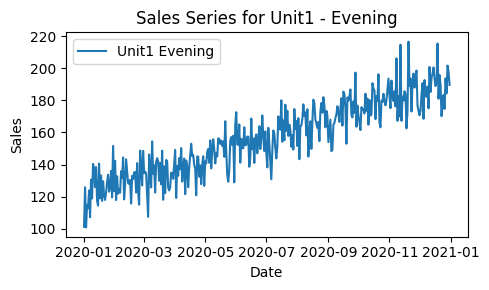

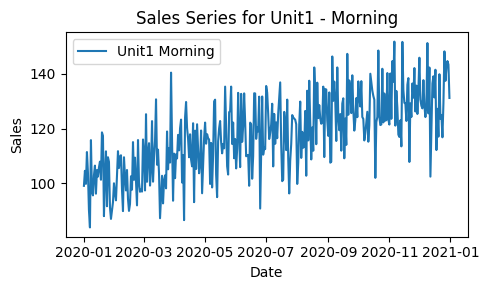

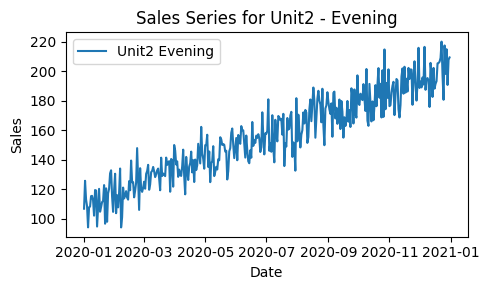

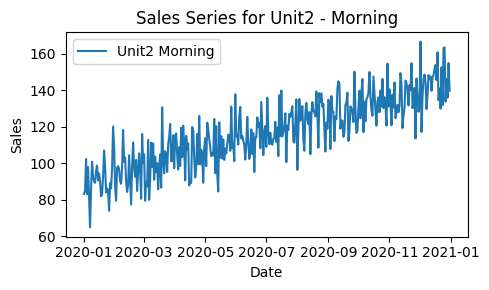

In [15]:
# plot the series

# Group by Unit and Shift
groups = df.groupby(['Unit', 'Shift'])

# Loop through each group and plot the series
for (unit, shift), group in groups:
    plt.figure(figsize=(5, 3))
    plt.plot(group['Date'], group['Sales'], linestyle='-', label=f'{unit} {shift}')
    plt.title(f'Sales Series for {unit} - {shift}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Define a function to test stationarity and seasonal differencing needs
def check_stationarity(series, kpss_alpha=0.05, m=7):
    # KPSS test for stationarity (null hypothesis: series is stationary)
    try:
        stat, p_value, lags, crit = kpss(series, regression='c', nlags='auto')
    except Exception:
        # In case of error (e.g., very short series), assume stationarity
        p_value = 1.0
    difference = 1 if p_value < kpss_alpha else 0

    # Seasonal differencing test using nsdiffs (based on Canova-Hansen)
    seasonal_order = nsdiffs(series, m=m, test='ch')
    seasonal_difference = 1 if seasonal_order > 0 else 0

    return difference, seasonal_difference

# Assuming df is your DataFrame with columns:
# 'Date', 'Unit', 'Shift', 'WeekdayName', 'HolidayYN', 'Sales'
results = []

# Group the data by Unit and Shift
for (unit, shift), group in df.groupby(['Unit', 'Shift']):
    # Ensure the series is sorted by Date
    group_sorted = group.sort_values('Date')
    sales_series = group_sorted['Sales']
    
    # Check for unit root and seasonal unit root
    diff, seas_diff = check_stationarity(sales_series)
    
    results.append({
        'Unit': unit,
        'Shift': shift,
        'difference': diff,
        'seasonal_difference': seas_diff
    })

# Create the resulting DataFrame
stationary_df = pd.DataFrame(results)

# Display the output
print(stationary_df)

    Unit    Shift  difference  seasonal_difference
0  Unit1  Evening           1                    0
1  Unit1  Morning           1                    0
2  Unit2  Evening           1                    0
3  Unit2  Morning           1                    0
